In [50]:
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import layers, models, optimizers
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D
from sklearn.model_selection import train_test_split
import requests
from io import BytesIO
from zipfile import ZipFile
import json
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.utils import load_img, image_dataset_from_directory

-----------------
# Read train and test sets

In [51]:
training_set = [(i, l) for i, l in image_dataset_from_directory('trafficsigns/train', image_size = (128, 128), batch_size = None, seed = 123)]
test_set = [(i, l) for i, l in image_dataset_from_directory('trafficsigns/test', image_size = (128, 128), batch_size = None, seed = 123)]

with open("classlabels.txt") as infile:
    labels = dict((int(i), j) for i, j in json.loads(infile.read()).items())
print("The 20 classes are: " + ", ".join(str(l) for l in labels.values()))

Found 1792 files belonging to 20 classes.
Found 1022 files belonging to 20 classes.
The 20 classes are: limit30, limit50, limit60, limit80, noleft, noright, nouturn, gostraight, goleft, goright, keepright, roundabout, danger, pedestrcross, bikecross, childcross, traincross, construction, nostopping, noentry


-----------
# Select labels

In [52]:
labels_to_keep = [0, 6, 4, 18] # Change this to determine which labels to keep (or change to list(range(20)) to keep all labels)
num_classes = len(labels_to_keep)

x_train = np.array([image for image, label in training_set if label in labels_to_keep])
y_train = np.array([labels_to_keep.index(label) for image, label in training_set if label in labels_to_keep])
x_test = np.array([image for image, label in test_set if label in labels_to_keep])
y_test = np.array([labels_to_keep.index(label) for image, label in test_set if label in labels_to_keep])

finallabels = dict([(i, labels[l]) for i, l in enumerate(labels_to_keep)])
print("The " + str(num_classes) + " classes are: " + ", ".join(str(l) for l in finallabels.values()))

The 4 classes are: limit30, nouturn, noleft, nostopping


----------------
# Plot example data

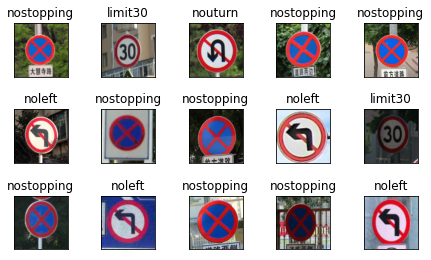

In [53]:
fig = plt.figure()
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.tight_layout()
    img = array_to_img(x_train[i])
    plt.imshow(img)
    plt.title(finallabels[y_train[i]])
    plt.xticks([])
    plt.yticks([])
plt.savefig("visualizations/example-data.png",bbox_inches='tight')

------------------------
# Explore and pre-process the data

In [54]:
# check the number of samples
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

564 train samples
402 test samples


In [55]:
type(x_train)

numpy.ndarray

In [56]:
x_train.shape # RGB images have a depth of 3

(564, 128, 128, 3)

In [57]:
x_test.shape

(402, 128, 128, 3)

In [58]:
x_train.min()

0.0

In [59]:
x_train.max()

255.0

In [60]:
# Normalize pixel values to be between 0 and 1 by dividing by 255. 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train, x_test = x_train / 255.0, x_test / 255.0

In [61]:
x_train.min()

0.0

In [62]:
x_train.max()

1.0

# Model

In [63]:
def create_CNN(input_shape, num_classes):
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(64, activation ='relu'))
    model.add(Dense(10))
    model.add(Dropout(0.5))  
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [64]:
input_shape = x_train.shape[1:4]
num_classes = 4

model = create_CNN(input_shape, num_classes)
adam = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])  

In [66]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(x_test, y_test))
scores = model.evaluate(x_test, y_test)

Epoch 1/10
18/18 [==============================] - 14s 743ms/step - loss: 1.1320 - accuracy: 0.5780 - val_loss: 0.9699 - val_accuracy: 0.6816
Epoch 2/10
18/18 [==============================] - 12s 693ms/step - loss: 0.7010 - accuracy: 0.7606 - val_loss: 0.7346 - val_accuracy: 0.7164
Epoch 3/10
18/18 [==============================] - 12s 681ms/step - loss: 0.4448 - accuracy: 0.8333 - val_loss: 0.6225 - val_accuracy: 0.6866
Epoch 4/10
18/18 [==============================] - 12s 702ms/step - loss: 0.3400 - accuracy: 0.8777 - val_loss: 0.5924 - val_accuracy: 0.6965
Epoch 5/10
18/18 [==============================] - 12s 677ms/step - loss: 0.2373 - accuracy: 0.9202 - val_loss: 0.5552 - val_accuracy: 0.7413
Epoch 6/10
18/18 [==============================] - 12s 691ms/step - loss: 0.1990 - accuracy: 0.9415 - val_loss: 0.5650 - val_accuracy: 0.7612
Epoch 7/10
18/18 [==============================] - 13s 705ms/step - loss: 0.1304 - accuracy: 0.9610 - val_loss: 0.7171 - val_accuracy: 0.7960

13/13 - 2s - loss: 0.6001 - accuracy: 0.7861 - 2s/epoch - 128ms/step


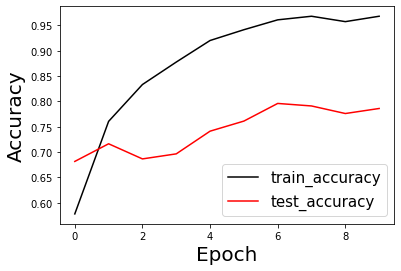

In [69]:
plt.plot(history.history['accuracy'], label='train_accuracy', color = 'k')
plt.plot(history.history['val_accuracy'], label = 'test_accuracy', color = 'r')
plt.xlabel('Epoch', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(loc='lower right', fontsize=15)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
plt.savefig("visualizations/accuracy_epoch.png",bbox_inches='tight')

13/13 - 2s - loss: 0.6001 - accuracy: 0.7861 - 2s/epoch - 148ms/step


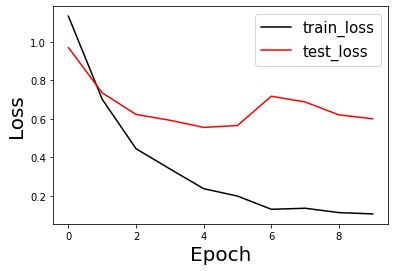

In [73]:
plt.plot(history.history['loss'], label='train_loss', color = 'k')
plt.plot(history.history['val_loss'], label = 'test_loss', color = 'r')
plt.xlabel('Epoch', size=20)
plt.ylabel('Loss', size=20)
plt.legend(loc='upper right', fontsize=15)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
plt.savefig("visualizations/loss_epoch.png",bbox_inches='tight')

In [ ]:
def build_fully_connected(input_shape, num_classes):
    """
    Create a fully-connected model to train or test on UC Merced dataset.
    """
    model = Sequential()
    model.add(Flatten(input_shape=(128, 128, 3)))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [ ]:
# Build, compile, and fit the model
model = build_fully_connected(input_shape=x_train.shape[1:4], num_classes=4)
adam = optimizers.Adam(lr=0.0001)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=1,  validation_data=(x_test, y_test))

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy', color = 'k')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy', color = 'r')
plt.xlabel('Epoch', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(loc='lower right', fontsize=15)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
#plt.savefig("visualizations/accuracy_epoch.png",bbox_inches='tight')

In [ ]:
plt.plot(history.history['loss'], label='loss', color = 'k')
plt.plot(history.history['val_loss'], label = 'val_loss', color = 'r')
plt.xlabel('Epoch', size=20)
plt.ylabel('Loss', size=20)
plt.legend(loc='lower right', fontsize=15)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
#plt.savefig("visualizations/loss_epoch.png",bbox_inches='tight')

In [ ]:
def create_convolutional_neural_network_keras(input_shape, receptive_field,
                                              n_filters, n_neurons_connected, n_categories,
                                              eta, lmbd):
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(Flatten(input_shape=x_train.shape[1:4]))
    model.add(Dense(64, activation ='relu'))
    model.add(Dense(10))
    model.add(Dropout(0.5))  
    model = build_fully_connected(input_shape=x_train.shape[1:4], num_classes=4)
    adam = optimizers.Adam(lr=0.0001)
    model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])  
    return model

epochs = 10
batch_size = 32
input_shape = x_train.shape[1:4]
receptive_field = 3
n_filters = 10
n_neurons_connected = 20
n_categories = 4

eta_vals = np.logspace(-5, 1, 7)
lmbd_vals = np.logspace(-5, 1, 7)

In [ ]:
CNN_keras = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
        
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        CNN = create_convolutional_neural_network_keras(input_shape, receptive_field,
                                              n_filters, n_neurons_connected, n_categories,
                                              eta, lmbd)
        history = CNN.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test, y_test))
        scores = CNN.evaluate(x_test, y_test)
        
        CNN_keras[i][j] = CNN
        
        print("Learning rate = ", eta)
        print("Lambda = ", lmbd)
        print("Test accuracy: %.3f" % scores[1])
        print()

In [ ]:
# visual representation of grid search
# uses seaborn heatmap, could probably do this in matplotlib
import seaborn as sns

sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        CNN = CNN_keras[i][j]

        train_accuracy[i][j] = CNN.evaluate(x_train, y_train)[1]
        test_accuracy[i][j] = CNN.evaluate(x_test, y_test)[1]

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
#plt.savefig("visualizations/train_accuracy.png",bbox_inches='tight')
#plt.savefig("visualizations/train_accuracy.eps",bbox_inches='tight')
#lt.savefig("visualizations/train_accuracy.pdf",bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
#plt.savefig("visualizations/test_accuracy.png",bbox_inches='tight')
#plt.savefig("visualizations/test_accuracy.eps",bbox_inches='tight')
#plt.savefig("visualizations/test_accuracy.pdf",bbox_inches='tight')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy', color = 'k')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy', color = 'r')
plt.xlabel('Epoch', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(loc='lower right', fontsize=15)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
#plt.savefig("visualizations/accuracy_epoch.png",bbox_inches='tight')

In [ ]:
plt.plot(history.history['loss'], label='loss', color = 'k')
plt.plot(history.history['val_loss'], label = 'val_loss', color = 'r')
plt.xlabel('Epoch', size=20)
plt.ylabel('Loss', size=20)
plt.legend(loc='lower right', fontsize=15)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
#plt.savefig("visualizations/loss_epoch.png",bbox_inches='tight')